(Note: out of date. Going to update.)

**Description**: Distributions of some marginal effects. These plots are much easier to
interpret than ones about $\beta$.

**Runtime**: ~3 min.

**Required data**: posterior samples are stored in `main_*.nc` files which can be
downloaded [from this Google Drive
folder](https://drive.google.com/drive/folders/1Pwe4Ky1LMhh9ATfojGUMN4UEwHEnFwHy?usp=sharing),
or saved locally by running [`main_200.ipynb`](./main_200.ipynb) and
[`main_500.ipynb`](./main_500.ipynb).

In [1]:
import os
from typing import Literal

import arviz as az
import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns
from tqdm.auto import tqdm

import utils

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
sns.set_theme(style="darkgrid")

In [3]:
num_train: Literal[50, 100] = 100
num_tests: list[int] = [200, 500]
accuracies_home_dir = "accuracies_from_paper"

In [4]:
effect_to_name: dict[str, str] = {
    "control": "pretraining boost",
    "treatment": "evaluation bias",
}

In [5]:
num_test_to_num_correct_df = {
    num_test: utils.load_all_num_correct(
        os.path.join(accuracies_home_dir, f"m{num_train}"), num_test
    )
    for num_test in num_tests
}

In [6]:
netcdfs_path = os.path.join("netcdfs", f"m{num_train}")
num_test_to_effect_to_summary = {
    num_test: {
        effect: az.from_netcdf(
            os.path.join(netcdfs_path, f"main_m{num_train}_n{num_test}_{effect}.nc")
        )
        for effect in effect_to_name
    }
    for num_test in num_tests
}

In [7]:
num_test_to_diffs_df: dict[int, pl.DataFrame] = {}
for num_test in tqdm(num_tests, "Processing treatment and control datasets"):
    num_test_to_diffs_df[num_test] = pl.DataFrame(
        {
            effect: utils.posterior_marginal_mean_diffs(
                num_test_to_effect_to_summary[num_test][effect],
                num_test_to_num_correct_df[num_test],
            )
            for effect in effect_to_name
        }
    )

Processing treatment and control datasets:   0%|          | 0/2 [00:00<?, ?it/s]

Marginalizing each draw (n = 200):   0%|          | 0/4000 [00:00<?, ?it/s]

Marginalizing each draw (n = 200):   0%|          | 0/4000 [00:00<?, ?it/s]

Marginalizing each draw (n = 500):   0%|          | 0/4000 [00:00<?, ?it/s]

Marginalizing each draw (n = 500):   0%|          | 0/4000 [00:00<?, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


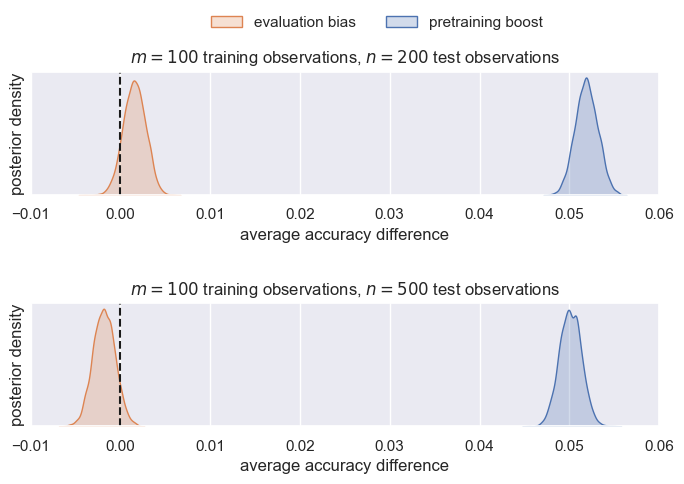

In [8]:
fig, axes = plt.subplots(nrows=len(num_tests), ncols=1)
fig.set_size_inches(7, (2 * len(num_tests)))
xlim = (-0.01, 0.06)
axes: list[plt.Axes]
for subplot_idx, (num_test, diffs_df) in enumerate(num_test_to_diffs_df.items()):
    ax = axes[subplot_idx]
    _ = ax.set_xlim(xlim)
    _ = sns.kdeplot(ax=ax, data=diffs_df.rename(effect_to_name).to_pandas(), fill=True)
    ax.axvline(0, linestyle="dashed", color="k")
    _ = ax.set_xlabel("average accuracy difference")
    _ = ax.set_ylabel("posterior density")
    _ = ax.set_yticks([])
    _ = ax.set_title(
        f"$m={{{num_train}}}$ training observations, "
        f"$n={{{num_test}}}$ test observations"
    )

# fig.suptitle(f"Average accuracy differences\n", y=1.01)
fig.legend(
    handles=reversed(ax.legend_.legend_handles),
    labels=reversed([t.get_text() for t in ax.legend_.get_texts()]),
    ncol=2,
    loc="upper center",
    frameon=False,
    bbox_to_anchor=(0.55, 1.07),
)

for ax in axes:
    ax.legend().set_visible(False)

fig.tight_layout()
plt.subplots_adjust(bottom=0.01)

We're looking at the distribution of $\frac{\bar{\hat{Y}}_{\cdot \cdot \cdot 1} -
\bar{\hat{Y}}_{\cdot \cdot \cdot 0}}{n}$, i.e., the difference between the treatment
($1$) and control ($0$) grand means. The mean is taken across LM types, classification
tasks, and their subsamples. We could produce conditional plots for each of these
groups, but rn I want to summarize the results.

We've sanity checked that pretraining is clearly beneficial across $n$. The boost in
accuracy is practically significant.

There evaluation bias is not. It bounces around 0. But even the big bounces aren't
enough to make a difference on most leaderboards / in most practical settings.